# Regressão Linear com NumPy

## Objetivos deste experimento

Este exemplo utiliza regressão linear para estimar o comprimento das sépalas da íris a partir do seu comprimento das pétalas.
Utiliza-se programação totalmente NumPy com:
- o **cálculo do gradiente**,
- a **função de perda** e
- a atualização dos parâmetros são feitos de forma explícita.
- A rede é criada com uma camada como uma classe

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoLinear_Otimizacao.png)

## Importação dos pacotes

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt   # para plotting

from sklearn.datasets import load_iris  # para carregar dataset

import numpy as np  # processamento matricial

np.random.seed(1234)

## Dataset

### Leitura dos dados

In [2]:
iris = load_iris()
data = iris.data[iris.target==1,::2]  # comprimento das sépalas e pétalas, indices 0 e 2

x_train = data[:,0:1]
y_train = data[:,1:2]

n_samples = x_train.shape[0]
print('x_train.shape:',x_train.shape, x_train.dtype)
print('y_train.shape:',y_train.shape, y_train.dtype)

print('x_train[:5]:\n', x_train[:5])
print('y_train[:5]:\n', y_train[:5])

x_train.shape: (50, 1) float64
y_train.shape: (50, 1) float64
x_train[:5]:
 [[7. ]
 [6.4]
 [6.9]
 [5.5]
 [6.5]]
y_train[:5]:
 [[4.7]
 [4.5]
 [4.9]
 [4. ]
 [4.6]]


### Normalização dos dados

In [3]:
x_train -= x_train.min()
x_train /= x_train.max()
y_train -= y_train.min()
y_train /= y_train.max()

Text(0, 0.5, 'Comprimento petalas')

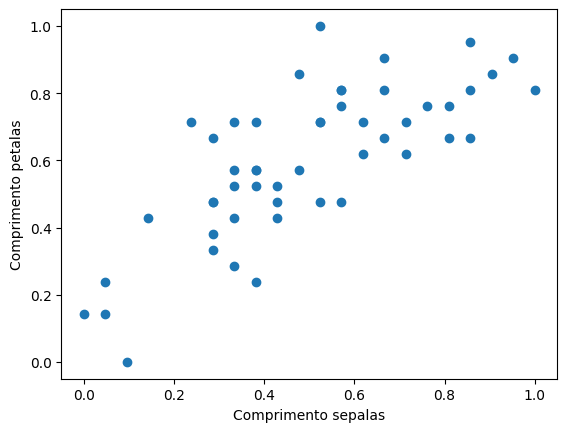

In [4]:
plt.scatter(x_train,y_train)
plt.xlabel('Comprimento sepalas')
plt.ylabel('Comprimento petalas')

## Modelo da rede

### Reta de ajuste

A equação da reta no plano necessita de dois parâmetros, aqui denominados $w_0$ (*bias*) e inclinação $w_1$. Veja figura:

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/linhareta.png)

A reta de ajuste será dada por:

$$ \hat{y} = w_0 + w_1 x $$

onde
* $w_1$ é o coeficiente angular da reta e
* $w_0$ é a interseção do eixo vertical quando x é igual a zero, também denominado de *bias*.
* $x$ é a variável de entrada (comprimento das sépalas) e
* $\hat{y}$ é a predição (comprimento estimado das pétalas).

### Linear Regression Model

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoLinearNeuronio.png)

### Formulação matricial do neurônio

* $\mathbf{w} = [w_0 \ w_1]$ é vetor linha de parâmetros e
* $\mathbf{x} = [1 \ x_0] $ é vetor linha de uma amostra (com *bias*).

$$ \hat{y} = 1 w_0 + x_0 w_1 $$

$$ [\hat{y}] = [1 \ x_0] \begin{bmatrix} w_0 \\ w_1 \end{bmatrix} $$

$$ \mathbf{\hat{y}} = \mathbf{x} \mathbf{w^T} $$

### Fazendo o predict de várias amostras

$$ \begin{matrix}
\begin{bmatrix}
\hat{y}_0\\
\hat{y}_1\\
\\
\hat{y}_{M-1}
\end{bmatrix} &=& \begin{bmatrix}
1 & x_0 \\
1 & x_1\\
\\
1 & x_{M-1} \\
\end{bmatrix}
&
\begin{bmatrix}
w_0\\
w_1
\end{bmatrix} \\
(M,1) & & (M,2) & (2,1) \\
\end{matrix} $$

### Preenchendo x com coluna de 1's para bias

In [5]:
x_train_bias = np.hstack([np.ones(shape=(n_samples,1)), x_train])

In [6]:
x_train_bias

array([[1.        , 1.        ],
       [1.        , 0.71428571],
       [1.        , 0.95238095],
       [1.        , 0.28571429],
       [1.        , 0.76190476],
       [1.        , 0.38095238],
       [1.        , 0.66666667],
       [1.        , 0.        ],
       [1.        , 0.80952381],
       [1.        , 0.14285714],
       [1.        , 0.04761905],
       [1.        , 0.47619048],
       [1.        , 0.52380952],
       [1.        , 0.57142857],
       [1.        , 0.33333333],
       [1.        , 0.85714286],
       [1.        , 0.33333333],
       [1.        , 0.42857143],
       [1.        , 0.61904762],
       [1.        , 0.33333333],
       [1.        , 0.47619048],
       [1.        , 0.57142857],
       [1.        , 0.66666667],
       [1.        , 0.57142857],
       [1.        , 0.71428571],
       [1.        , 0.80952381],
       [1.        , 0.9047619 ],
       [1.        , 0.85714286],
       [1.        , 0.52380952],
       [1.        , 0.38095238],
       [1.

### Classe com o modelo da rede

In [7]:
class Net():
    def __init__(self, n_in, n_out):
        self.w = np.random.uniform(-0.1,0.1,(n_out,n_in)) #inicialização dos parâmetros

    def forward(self, x_bias):
        return x_bias.dot(self.w.T)

### Criando a rede, instanciando o objeto model

In [47]:
model = Net(2,1) # duas entradas (1 + x0) e uma saída y_pred

### Testando o predict da rede (mesmo sem treiná-la)

In [48]:
xin = np.random.randn(4,2) # 4 amostras, 2 entradas (1 + x0)
ypred = model.forward(xin)
ypred

array([[ 0.00743076],
       [-0.02671039],
       [-0.0758467 ],
       [-0.05381149]])

## Treinamento via gradiente descendente

Função de perda:
$$ J(\hat{y_i},y_i) = \frac{1}{M} \sum_{i=0}^{M-1} (\hat{y_i} - y_i)^2 $$

Gradiente:
$$  \mathbf{\nabla{J_w}} = \frac{2}{M}\mathbf{x^T}(\mathbf{x w^T} - \mathbf{y}) $$

Atualização dos parâmetros pelo gradiente descendente:
$$ \mathbf{w} = \mathbf{w} − \eta (\mathbf{\nabla J_w})^T $$

### Laço de treinamento

In [49]:
num_epochs = 100
learning_rate = 0.5
for epoch in range(num_epochs):

    # forward - predict
    y_pred = model.forward(x_train_bias)

    #loss cálculo da função de perda
    loss = np.square(y_pred - y_train).mean()

    # cálculo do gradiente pelas derivadas parciais
    w_grad = (2.0/n_samples) * (x_train_bias.T).dot(x_train_bias.dot(model.w.T) - y_train)

    # gradiente descendente
    model.w = model.w - learning_rate * w_grad.T

    # verbose
    if (epoch+1) % 1 == 0:
        print('Epoch[{}/{}], loss: {:.6f}'
              .format(epoch+1, num_epochs, loss))

Epoch[1/100], loss: 0.499597
Epoch[2/100], loss: 0.059285
Epoch[3/100], loss: 0.029923
Epoch[4/100], loss: 0.027430
Epoch[5/100], loss: 0.026744
Epoch[6/100], loss: 0.026223
Epoch[7/100], loss: 0.025757
Epoch[8/100], loss: 0.025335
Epoch[9/100], loss: 0.024951
Epoch[10/100], loss: 0.024603
Epoch[11/100], loss: 0.024287
Epoch[12/100], loss: 0.023999
Epoch[13/100], loss: 0.023739
Epoch[14/100], loss: 0.023502
Epoch[15/100], loss: 0.023287
Epoch[16/100], loss: 0.023092
Epoch[17/100], loss: 0.022915
Epoch[18/100], loss: 0.022754
Epoch[19/100], loss: 0.022608
Epoch[20/100], loss: 0.022476
Epoch[21/100], loss: 0.022356
Epoch[22/100], loss: 0.022246
Epoch[23/100], loss: 0.022147
Epoch[24/100], loss: 0.022057
Epoch[25/100], loss: 0.021975
Epoch[26/100], loss: 0.021901
Epoch[27/100], loss: 0.021834
Epoch[28/100], loss: 0.021773
Epoch[29/100], loss: 0.021717
Epoch[30/100], loss: 0.021667
Epoch[31/100], loss: 0.021621
Epoch[32/100], loss: 0.021579
Epoch[33/100], loss: 0.021541
Epoch[34/100], loss

## Avaliação

### Predict

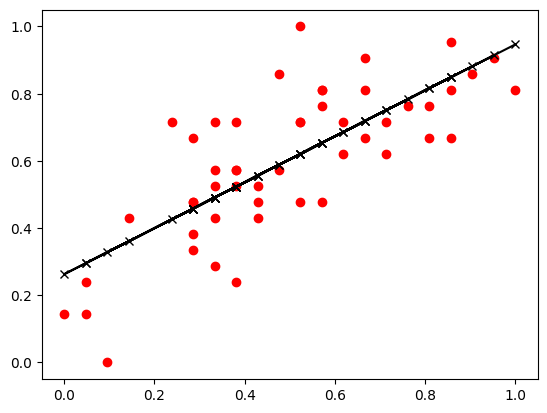

In [50]:
y_pred = model.forward(x_train_bias)
plt.plot(x_train, y_train, 'ro', label='Original data')
plt.plot(x_train, y_pred, 'kx-', label='Fitting Line')

### Parâmetros treinados

In [51]:
print(model.w)

[[0.26287051 0.68351675]]


### Avaliação do modelo

In [52]:
loss = np.square(y_pred - y_train).mean()
loss

0.02116994562106846

### Valor ótimo, solução analítica

$$  \mathbf{w} =(\mathbf{x^T} \mathbf{x})^{−1}\mathbf{x^T} \mathbf{y} $$

In [53]:
x = x_train_bias
y = y_train
w_opt = (np.linalg.inv((x.T).dot(x)).dot(x.T)).dot(y)
print(w_opt.T)

[[0.26134159 0.68646976]]


# Exercícios

## Questões

1. Quantos parâmetros são treinados nesse modelo?
Resp.: 2 parâmetros, w0 e w1.

2. Qual é o número de atributos de entrada para a rede?
Resp.: Apenas 1, o valor de x0

3. Qual é o número de saídas da rede?
Resp.: Apenas 1, o valor de y^ que é o valor da predição.

4. Suponha que eu tenha agora 5 mil amostras para fazer a predição.

Qual é o shape da matriz de entrada? Resp.: [5000, 2] (5000 amostras onde serão 5000 valores de bias (1) e de x0)

Qual é o shape do matriz de saída? Resp.: [5000, 1] (5000 amostrar onde serão 5000 valores de y^ preditos)


## Atividades

1. Modifique o laço do treinamento via gradiente descendente para guardar em uma lista, o valor da perda no final
   de cada época. Após o treinamento, plote o valor da perda em função da época.
2. Calcule o valor da perda (MSE) da rede com os parâmetros inicializados, sem serem treinados.
3. Coloque os valores dos pesos da solução ótima analítica no modelo da rede e calcule o valor da perda (MSE) e
   compare com o valor da perda obtida pelo método da otimização via gradiente descendente.

#### 1. Modifique o laço do treinamento via gradiente descendente para guardar em uma lista, o valor da perda no final de cada época. Após o treinamento, plote o valor da perda em função da época.

In [54]:
#Cria a rede
model = Net(2,1) # duas entradas (1 + x0) e uma saída y_pred

In [55]:
num_epochs = 100
learning_rate = 0.3

loss_result = []
for epoch in range(num_epochs):

    # forward - predict
    y_pred = model.forward(x_train_bias)

    #loss cálculo da função de perda
    loss = np.square(y_pred - y_train).mean()
    loss_result.append(loss)

    # cálculo do gradiente pelas derivadas parciais
    w_grad = (2.0/n_samples) * (x_train_bias.T).dot(x_train_bias.dot(model.w.T) - y_train)

    # gradiente descendente
    model.w = model.w - learning_rate * w_grad.T

    # verbose
    if (epoch+1) % 20 == 0:
        print('Epoch[{}/{}], loss: {:.6f}'
              .format(epoch+1, num_epochs, loss))

Epoch[20/100], loss: 0.026557
Epoch[40/100], loss: 0.022878
Epoch[60/100], loss: 0.021712
Epoch[80/100], loss: 0.021341
Epoch[100/100], loss: 0.021224


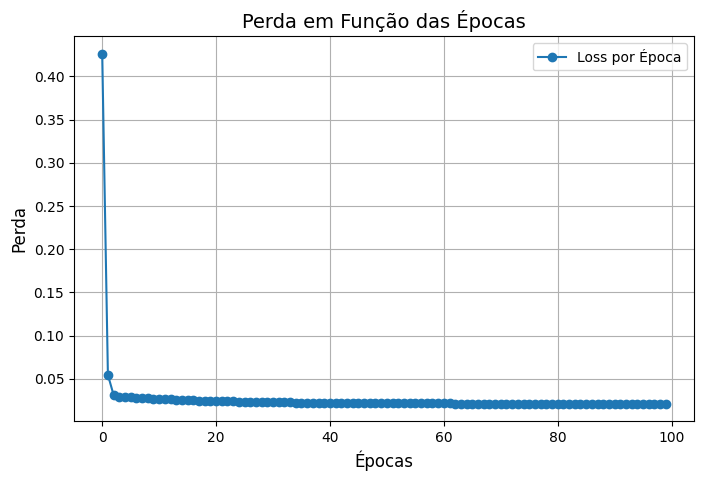

In [29]:
#Plot do Gráfico:
import matplotlib.pyplot as plt
import numpy as np

epochs = range(num_epochs)

plt.figure(figsize=(8, 5))
plt.plot(epochs, loss_result, marker='o', label='Loss por Época')
plt.title("Perda em Função das Épocas", fontsize=14)
plt.xlabel("Épocas", fontsize=12)
plt.ylabel("Perda", fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

#### 2. Calcule o valor da perda (MSE) da rede com os parâmetros inicializados, sem serem treinados.

In [38]:
model2 = Net(2,1)
print(model2.w)

[[ 0.06042953 -0.07124664]]


In [39]:
#Calculo da Perda
# forward - predict
y_pred2 = model2.forward(x_train_bias)

#loss cálculo da função de perda
loss2 = np.square(y_pred2 - y_train).mean()
print(loss2)

0.3854640432804148


#### 3. Coloque os valores dos pesos da solução ótima analítica no modelo da rede e calcule o valor da perda (MSE) e compare com o valor da perda obtida pelo método da otimização via gradiente descendente.

In [56]:
#Criação da Rede 3
model3 = Net(2,1)

#Avaliação do valor ótimo:
x = x_train_bias
y = y_train
w_opt3 = (np.linalg.inv((x.T).dot(x)).dot(x.T)).dot(y)

#Atribuindo à rede 3 do valor ótimo
model3.w[0][0], model3.w[0][1] = w_opt3[0], w_opt3[1]

<ipython-input-56-1fc07f19dc53>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  model3.w[0][0], model3.w[0][1] = w_opt3[0], w_opt3[1]


In [57]:
#Calculo da perda do valor ótimo
# forward - predict
y_pred_otimo = model3.forward(x_train_bias)

#loss cálculo da função de perda
loss_otimo = np.square(y_pred_otimo - y_train).mean()

y_pred_treinamento = model.forward(x_train_bias)
loss_treinamento = np.square(y_pred_treinamento - y_train).mean()

In [58]:
print(f"Perda de Treinamento = {loss_treinamento}")
print(f"Perda de Ótimo = {loss_otimo}")

Perda de Treinamento = 0.021220926461076907
Perda de Ótimo = 0.021169424119097165


# Aprendizados